<a href="https://colab.research.google.com/github/sooonsyk/24-2-ml-project/blob/main/LeNet_sooyeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alzheimer MRI Disease Classification**

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.



## **LeNet**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Epoch [1/15] - Train Loss: 1.0637, Train Acc: 0.4783, Test Loss: 1.0050, Test Acc: 0.4969
Epoch [2/15] - Train Loss: 0.9667, Train Acc: 0.5266, Test Loss: 0.9333, Test Acc: 0.5234
Epoch [3/15] - Train Loss: 0.9240, Train Acc: 0.5559, Test Loss: 0.8906, Test Acc: 0.5711
Epoch [4/15] - Train Loss: 0.8889, Train Acc: 0.5646, Test Loss: 0.9662, Test Acc: 0.5414
Epoch [5/15] - Train Loss: 0.8693, Train Acc: 0.5787, Test Loss: 0.8630, Test Acc: 0.5859
Epoch [6/15] - Train Loss: 0.8518, Train Acc: 0.5816, Test Loss: 0.8553, Test Acc: 0.5852
Epoch [7/15] - Train Loss: 0.8168, Train Acc: 0.6023, Test Loss: 0.8500, Test Acc: 0.6039
Epoch [8/15] - Train Loss: 0.7816, Train Acc: 0.6273, Test Loss: 0.7484, Test Acc: 0.6539
Epoch [9/15] - Train Loss: 0.6913, Train Acc: 0.6789, Test Loss: 0.6831, Test Acc: 0.6961
Epoch [10/15] - Train Loss: 0.5702, Train Acc: 0.7541, Test Loss: 0.5965, Test Acc: 0.7383
Epoch [11/15] - Train Loss: 0.4133, Train Acc: 0.8281, Test Loss: 0.4373, Test Acc: 0.8227
Epoch [1

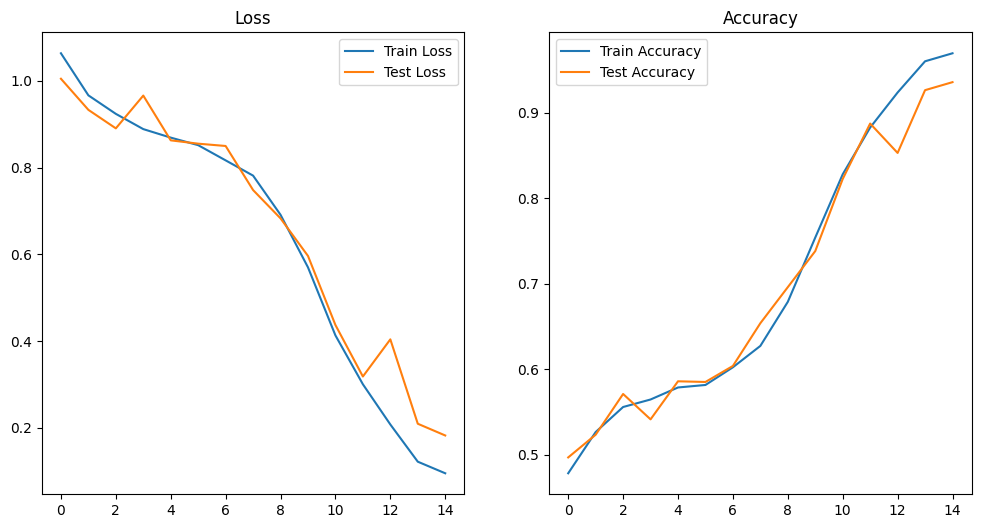

F1-Score: 0.9360, Accuracy: 0.9359


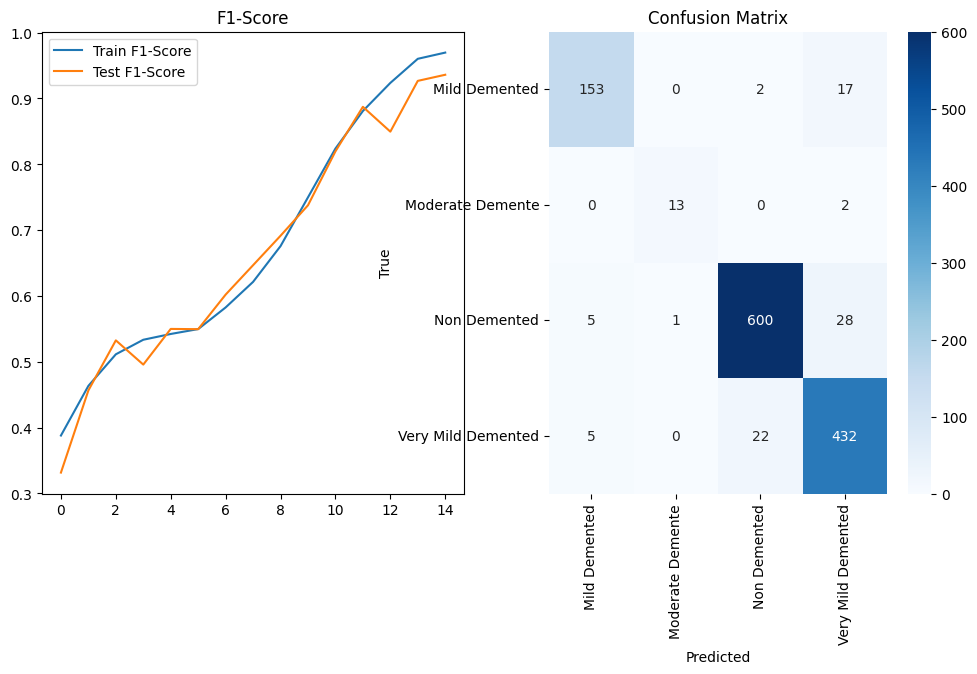

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Load Dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# 2. Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert to PyTorch Tensor
])

# 3. Define PyTorch Dataset
class AlzheimerMRIDataset(Dataset):
    def __init__(self, dataset, num_classes, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.num_classes = num_classes  # Number of classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access row
        item = self.dataset[idx]
        # Load image
        image = item['image']  # Should be PIL Image or JpegImageFile
        # Apply transformation if defined
        if self.transform:
            image = self.transform(image)
        # Load label
        label = item['label']

        return image, label

# 4. Determine Number of Classes
# Assuming the labels are integers starting from 0 to the number of classes-1
num_classes = len(set(item['label'] for item in train_dataset))  # Get unique classes

# 5. Create PyTorch Dataset
train_dataset = AlzheimerMRIDataset(train_dataset, num_classes=num_classes, transform=transform)
test_dataset = AlzheimerMRIDataset(test_dataset, num_classes=num_classes, transform=transform)

# 6. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_shape = train_dataset[0][0].shape
output_shape = train_dataset.num_classes


## model definition

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0)
        )

        self.flatten = nn.Flatten()

        self.fcs = nn.Sequential(
            nn.Linear(64*32*32,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, output_shape)
        )


    def forward(self,x):

        hidden = self.fe(x)
        hidden = self.flatten(hidden)
        output = self.fcs(hidden)

        return output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)


num_epochs = 15
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []
train_f1_list, test_f1_list = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0
    y_true_train, y_pred_train = [], []

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Forward pass
        y_pred = model(x)

        # Calculate loss
        loss = loss_function(y_pred, y)
        total_loss += loss.item() * x.size(0)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, preds = torch.max(y_pred, 1)
        correct_train += torch.sum(preds == y).item()
        total_train += y.size(0)

        # Collect true and predicted labels for F1-score
        y_true_train.extend(y.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    # Compute average loss and accuracy
    avg_train_loss = total_loss / total_train
    train_accuracy = correct_train / total_train
    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)
    train_f1_list.append(train_f1)

    # Evaluation on the test set
    model.eval()
    total_loss, correct_test, total_test = 0, 0, 0
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            # Calculate loss
            loss = loss_function(y_pred, y)
            total_loss += loss.item() * x.size(0)

            # Calculate accuracy
            _, preds = torch.max(y_pred, 1)
            correct_test += torch.sum(preds == y).item()
            total_test += y.size(0)

            # Collect true and predicted labels for F1-score
            y_true_test.extend(y.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    avg_test_loss = total_loss / total_test
    test_accuracy = correct_test / total_test
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(test_accuracy)
    test_f1_list.append(test_f1)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")



# 11. Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# 12. Calculate F1-Score and Confusion Matrix
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_true.extend(y.cpu().numpy())
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())

# F1-Score and Accuracy
f1 = f1_score(y_true, y_pred, average='weighted')
acc = accuracy_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}, Accuracy: {acc:.4f}")

# F1 score and Confusion Matrix
label_names = ["Mild Demented", "Moderate Demente", "Non Demented", "Very Mild Demented"]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_f1_list, label='Train F1-Score')
plt.plot(test_f1_list, label='Test F1-Score')
plt.legend()
plt.title('F1-Score')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()